*JSC270, Winter 2020 - Prof. Chevalier*

# <center>  Assignment 2 - Yelp  </center>
<center> Karl Hendrik Nurmeots, February 19, 2020 </center>



***

In [179]:
# Some of these packages may have to be conda installed instead of pip installed depending on your system
# Yes, this notebook needs them all
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from haversine import haversine, Unit
import seaborn as sns
import simplejson as json
import geopandas as gpd
import descartes
from shapely.geometry import Point, Polygon, mapping, shape, LineString
from shapely.ops import polygonize
import re
from fuzzywuzzy import fuzz
from sklearn.linear_model import LinearRegression
import string
import contextily as ctx
import geoplot as gplt
import geoplot.crs as gcrs
from shapely.wkt import loads
import scipy as scp
from typing import Tuple, Dict
from functools import partial
import pyproj
import shapely.ops as ops
import nltk
from nltk.corpus import stopwords

In [3]:
plt.style.use("ggplot")
plt.rcParams['figure.figsize'] = [15,7]

# Introduction

[Yelp](https://www.yelp.com/) is a business directory service and crowd-sourced review forum.

# The Yelp Dataset

For this report we will be using the [Yelp dataset](https://www.yelp.com/dataset/challenge). **For this report to compile, you must download the data from the website and place it in extracted form in the 'data' directory!** This requires you to provide your email and name.

Per the [Yelp dataset license](https://s3-media1.fl.yelpcdn.com/assets/srv0/engineering_pages/06cb5ad91db8/assets/vendor/yelp-dataset-agreement.pdf), one is allowed to create a report of the data such as this one only for academic purposes. Any sort of disclosure or sharing of the dataset itself is strictly prohibited - this is a private dataset. Any use of the dataset must not disparage Yelp.

A more detailed overview of the dataset can be found on the [dataset documentation page](https://www.yelp.com/dataset/documentation/main). Due to the comprehensive extent of the dataset we will only provide a short insight into what the dataset contains. The dataset consists of 6 JSON files: 

`business.json` contains information about each establishment in the dataset such as the business' name, ID, location (address and coordinates), Yelp rating and review count, attributes (e.g. if the business provides a takeout service), category, and opening hours.

`review.json` contains information about each review, namely the author ID, business reviewed ID, rating, date, full review text, and the number of "useful", "funny" and "cool" votes the review has recieved. Author ID maps to the corresponding user in user.json, and business ID maps to the business in business.json.

`user.json` contains information about users' IDs, first names, their friends' user IDs, and info about the feedback they have recieved on their reviews (e.g. total "useful" votes).

`checkin.json` contains each business' ID and a collection of timestamps when users have checked in at that business. Again, the business ID maps to business.json.

`tip.json` contains information about short tips that users have posted, and is structured similarly to review.json. Tips are essentially very short reviews, but do not give a numeric rating about the business. Instead of tracking the number of different votes, the number of "compliments" the tip has recieved is tracked.

`photo.json` contains metadata about photos users have posted: the business' ID the picture is about, the author's user ID, the picture's caption and label (e.g. "food"). 

For this analysis, we will only use `business.json` and `review.json`.

In [4]:
def json_to_dataframe(file: str, nrows = 0) -> pd.DataFrame:
    """Returns a Pandas dataframe from the JSON file located at <file>."""
    with open(file, 'r', encoding="utf8") as f:
        if nrows == 0:
            content = f.readlines()
        else:
            content = []
            for i in range(nrows):
                content.append(f.readline())
        
    return pd.DataFrame([json.loads(row) for row in content])

In [ ]:
# Reading in the 2 JSON files
business = json_to_dataframe("data/business.json")
review = json_to_dataframe("data/review.json")

# Analysis

Oddly enough, the dataset does not contain information about what country each business is located in, so to start off, let's visualize all of our businesses on a world map. For this and all following map visualizations we will be using the Mercator projection.

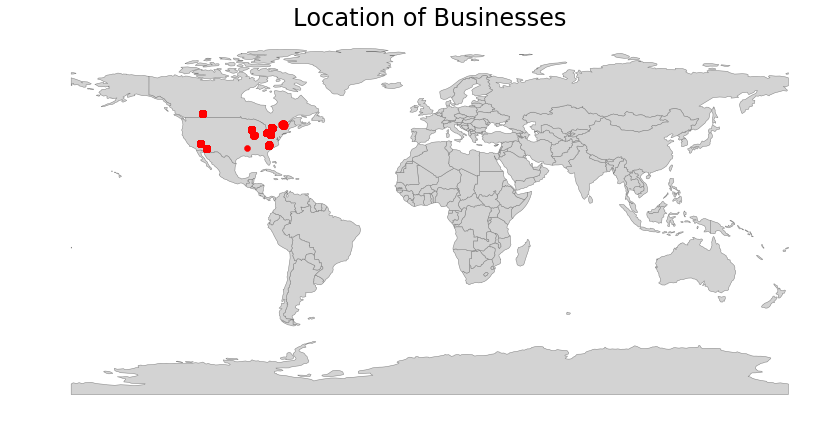

In [6]:
# Get world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# Create GeoDataFrame for business
gdf = gpd.GeoDataFrame(
    business, geometry=gpd.points_from_xy(business.longitude, business.latitude), crs=world.crs)

ax = world.plot(
    color='lightgrey', edgecolor='grey')

gdf.plot(ax=ax, color='red')

plt.title("Location of Businesses", fontsize=24)
plt.axis('off')
plt.show()

All of the businesses in the dataset are located either in the US or Canada. We have information about the businesses' postal codes, and we can notice that USA and Canada have different postal code formats: US postal codes include only numbers, while Canadian ones always include alphabetic letters, so we can easily create a new column `country` to distinguish the country the business is located in based on their postal code.

In [7]:
def get_country(row: pd.Series) -> str:
    """Given a Pandas series representing a row about a business, returns the country
       the business is located in.
       
       Note that postal codes in Canada always contain letters, while US postal codes do not."""
    
    if re.search('[a-zA-Z]', row.postal_code) is None:
        return "USA"
    return "Canada"

business['country'] = business.apply(lambda row: get_country(row), axis=1)

Let's see how the businesses in the dataset distribute in terms of the country they are located in:

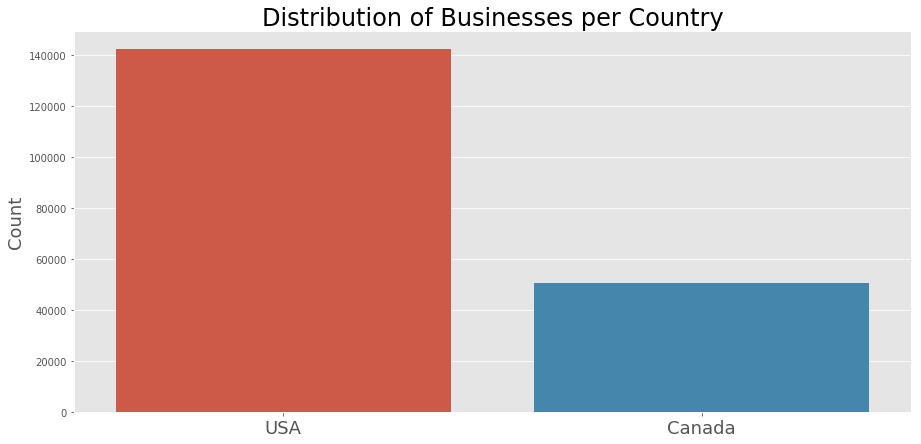

In [8]:
sns.countplot(x=business.country)

plt.title("Distribution of Businesses per Country", fontsize=24)
plt.ylabel("Count", fontsize=18)
plt.xlabel("")
plt.xticks(fontsize=18)
plt.show()

We can see that over 70% of the businesses in the dataset are located in the US.

Moving on, we would like to see how the businesses distribute across cities in the dataset. When we take a look at the different cities present in the dataset, however, we will realise that there are many inconsistencies in the city names: for example, both "Montréal" and "Montreal" show up.

We would like to fix this issue, so we will use FuzzyWuzzy, a fuzzy string matching package. Our businesses dataset is very large, and this type of string fixing is very demanding, so we will have to compromise: we will only try to fix the names of the largest 100 cities in the US and Canada (separately). A quick glimpse into the data tells us that most businesses are located in these cities, so it is also more likely that there are inconsistencies in the city names for these businesses.

More precisely, we will look at the biggest cities by population based on Wikipedia. Here's our reference data: [Canada](https://en.wikipedia.org/wiki/List_of_the_100_largest_municipalities_in_Canada_by_population) and [USA](https://en.wikipedia.org/wiki/List_of_United_States_cities_by_population).

In [9]:
# Reading in data from Wikipedia

url_ca = 'https://en.wikipedia.org/wiki/List_of_the_100_largest_municipalities_in_Canada_by_population'
url_usa = 'https://en.wikipedia.org/wiki/List_of_United_States_cities_by_population'

canada = pd.read_html(url_ca, attrs = {"class":"wikitable sortable"})[0]
canada_cities = canada.Municipality.values

usa = pd.read_html(url_usa, attrs = {"class":"wikitable sortable"})[0]
usa_cities = usa.City.values[:100]

# Reading in the USA cities data sometimes adds weird tags to the city names, so we will
# remove them.
for i in range(len(usa_cities)):
    usa_cities[i] = re.sub('\[.\]$', '', usa_cities[i])

In [10]:
def fix_city_name(row: pd.Series) -> str:
    """Given a Pandas Series representing a row about a business,
       returns the fuzzy corrected city name for that business."""
    city = row.city
    cutoff = 90
    
    # If we get a match of >= cutoff %, return that match.
    # Otherwise, return the original city name.
    if row.country == 'Canada':
        for ca in canada_cities:
            if fuzz.token_set_ratio(city, ca) >= cutoff:
                return ca
    else:
        for us in usa_cities:
            if fuzz.token_set_ratio(city, us) >= cutoff:
                return us
    return city

business['city'] = business.apply(lambda row: fix_city_name(row), axis=1)

With the city names corrected, we can take a look at how the businesses distribute based on the city they are located in:

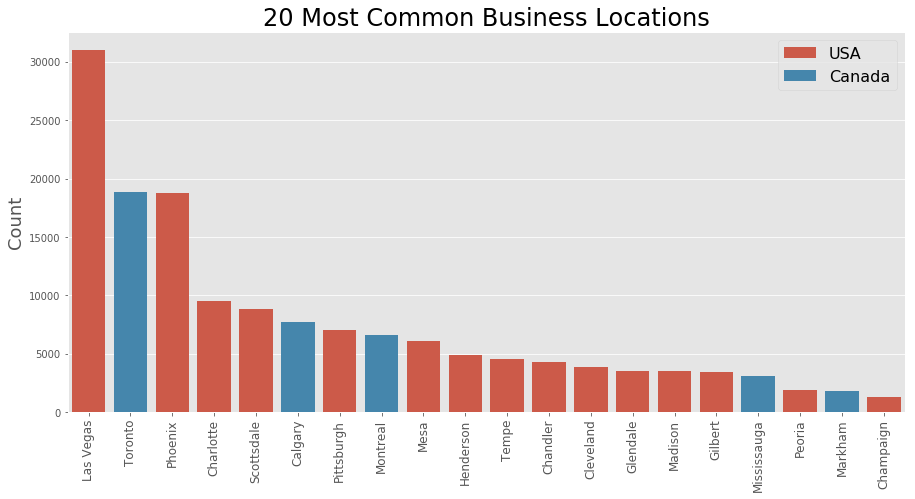

In [11]:
sns.countplot(business.city, order=business.city.value_counts().iloc[:20].index,
             hue=business.country, dodge=False)

plt.xticks(rotation=90)
plt.title("20 Most Common Business Locations", fontsize=24)
plt.ylabel("Count", fontsize=18)
plt.xlabel("")
plt.xticks(fontsize=12)
plt.legend(fontsize=16)

plt.show()

In total, there are just over 1000 different cities in the dataset, however the businesses in the top 20 most common cities account for about 78% of all the businesses in the dataset. As evident, this list is dominated by cities in the US, accompanied by some of the biggest cities in Canada. The most common city in the dataset is Las Vegas, which accounts for about 15% of all businesses.

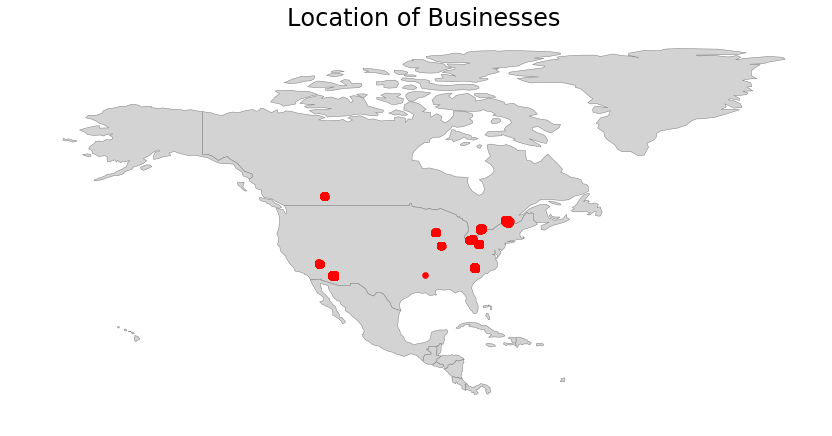

In [12]:
ax = world[world.continent=='North America'].plot(
    color='lightgrey', edgecolor='grey')

gdf.plot(ax=ax, color='red', alpha=1)

plt.title("Location of Businesses", fontsize=24)
plt.axis('off')
plt.show()

When we map the location of businesses, we can see that the dataset contains businesses from very few regions: most of them are clustered together in the east US and GTA area, with some others situated in the southwestern parts of the US and Canada.

### Business Categories

We would like to analyse what categories of businesses are present in the dataset. The dataset has a column `categories`, which contains usually multiple tags for each business. The data is not well formatted: for example, the most common value in `categories` is "Restaurants, Pizza", while the third most common value is "Pizza, Restaurants". Because of all of the different possible tags and their permutations, we need to reduce the number of categories to get a better overview of what's going on.

To do this, we will extract the separate category tags from the categories column (e.g. 'Pizza' and 'Restaurants' from 'Pizza, Restaurants'), and find the total count for how many times each such category shows up in the dataset. There are many different tags used in the dataset, so we will only look at the 20 most frequent ones.

In [13]:
# We are also extracting information about the availability of bike parking per category,
# which we will need later. It is more efficient to do this here

keywords = {}
# Iterate through df, extract category tag and bike parking availability counts
for i, bus in business.iterrows():
    cat = bus.categories
    att = bus.attributes
    if cat is not None:
        for word in cat.split(','):
            if word.strip() in keywords:
                keywords[word.strip()][0] += 1
            else:
                keywords[word.strip()] = [1, 0]
        
            if att is not None and 'BikeParking' in att and att['BikeParking'] == 'True':
                keywords[word.strip()][1] += 1

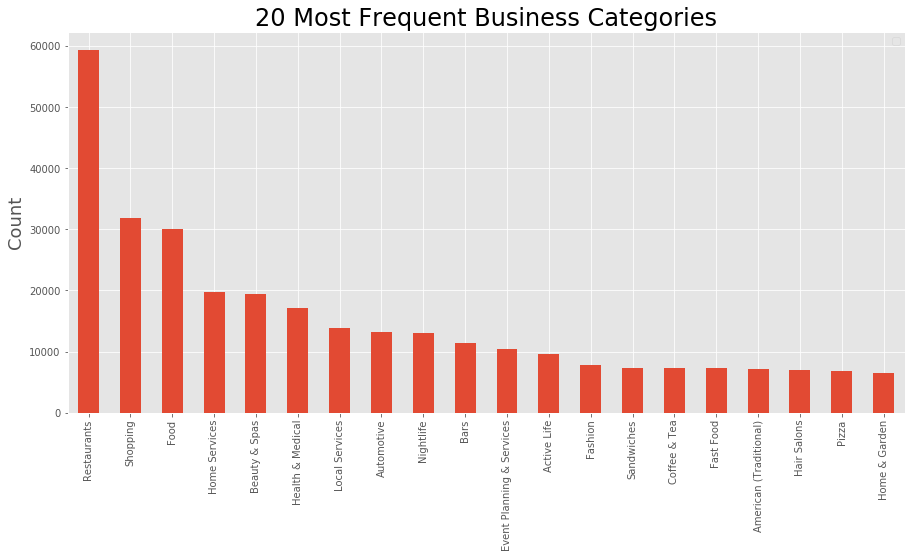

In [14]:
# Create new df containing top 20 categories based on count, and the number and proportion of such businesses
# that have bike parking available
cats = pd.DataFrame.from_dict(keywords, orient='index')
cats = cats.reset_index()
cats.columns = ['category', 'count', 'bike_parking']
cats['prop_bike_parking'] = cats.apply(lambda row: 100*row.bike_parking/row['count'], axis=1)
topcats = cats.sort_values('count', ascending=False).head(20)


topcats.plot.bar(x='category', y='count', label='')

plt.title("20 Most Frequent Business Categories", fontsize=24)
plt.ylabel("Count", fontsize=18)
plt.xlabel("")
plt.legend("")
plt.show()

For the most part, this sort of splitting works: most of the categories we are left with are "general" as they describe a very broad category of business. However, we can still see that there's likely some overlap: "Food", "Sandwiches", "Fast Food" and others could be considered subsets of "Restaurants". At the same time, not every business with the tag "Fast Food" is also tagged with "Restaurants", so in many cases there is no overlap.

To get a slightly better idea of what's going on, let's divide these categories into three simpler ones: Food & Drink, Retail, and Services. This sort of categorizing will not be perfect because some of the tags can be very vague: for example, notice "American (Traditional)". Presumably this denotes businesses that serve American food, however we can't exatly be sure either. The way we will categorize our business types is definitely subjective and debatable, but it will still give us a simplified overview of the situation.

In [15]:
def get_simple_category(row: pd.Series) -> str:
    """Given a Pandas Series representing a row about a business,
    returns whether this business belongs to one of our simple categories:
    'Food & Drink', 'Retail', or 'Services'. """
    # Define simple category based on category entry
    fnd=['Restaurants', 'Food', 'Bars', 'Sandwiches', 'Coffee & Tea',
         'Fast Food', 'American (Traditional)', 'Pizza', 'Chinese',
        'Speciality Food', 'Breakfast & Brunch', 'Canadian (New)', 'Italian']
    ret=['Shopping', 'Home & Garden', 'Fashion']
    # Everything else in the top 20 belongs to 'Services'
    
    if row.category in fnd:
        return "Food & Drink"
    elif row.category in ret:
        return "Retail"
    return "Services"

topcats['simple_cat'] = topcats.apply(lambda row: get_simple_category(row), axis=1)

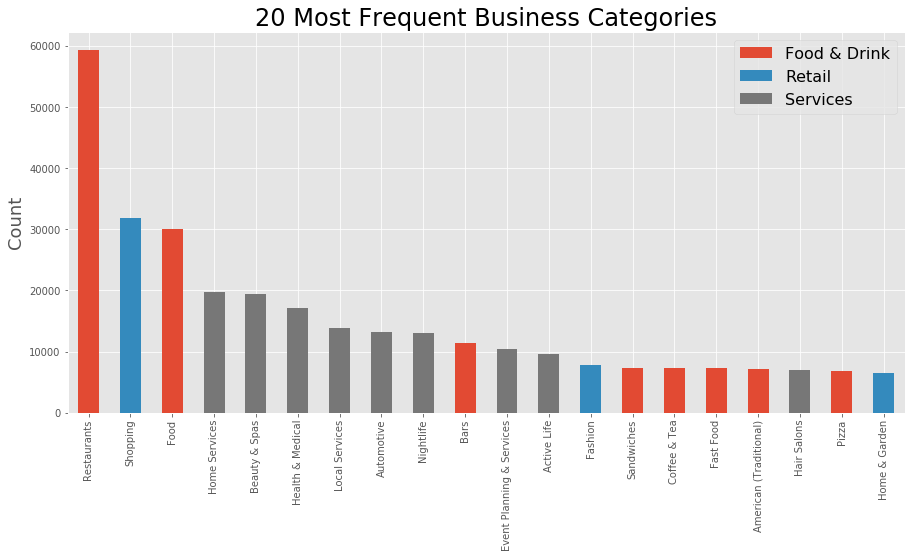

In [16]:
# Decide on bar color based on simple_cat. Skipping 'C2' for better contrast
color_dict = {'Food & Drink': 'C0', 'Retail': 'C1', 'Services': 'C3'}
colors = [color_dict[cat] for cat in topcats.simple_cat]

topcats.plot.bar(x='category', y='count', label='', color=colors)

# Create custom legend based on our colormapping
legend_elements = [Patch(facecolor='C0', label='Food & Drink'),
                  Patch(facecolor='C1', label='Retail'),
                  Patch(facecolor='C3', label='Services')]

plt.title("20 Most Frequent Business Categories", fontsize=24)
plt.ylabel("Count", fontsize=18)
plt.xlabel("")
plt.legend(handles=legend_elements, fontsize=16)
plt.show()

Let's also combine this with the total counts within the top 20 for our three simple categories:

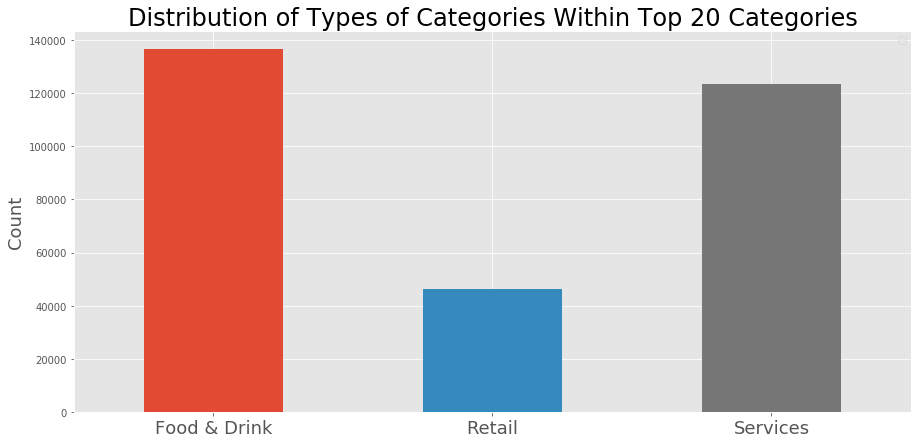

In [17]:
# Get total counts per simple_cat and create new df
# Again, we will keep track of bike parking for a later section, too
d = {'Food & Drink':[0, 0], "Retail":[0,0], "Services":[0,0]}
for i, row in topcats.iterrows():
    d[row.simple_cat][0] += row['count']
    d[row.simple_cat][1] += row.bike_parking
    
df = pd.DataFrame.from_dict(d, orient='index')
df = df.reset_index()
df.columns = ['cat', 'count', 'bike_parking']

df.plot.bar(x='cat', y='count', color=['C0', 'C1', 'C3'], label='')

plt.xticks(rotation=0, fontsize=18)
plt.xlabel("")
plt.ylabel("Count", fontsize=18)
plt.title("Distribution of Types of Categories Within Top 20 Categories", fontsize=24)
plt.legend("")
plt.show()

From these two visualizations we can see that food and drink categories are most common due to "Restaurants" and "Food" being so common, but they are closely followed by services categories, which consist of many categories with relatively smaller counts. Businesses dealing in retail are much less common among the most popular categories.

### Bike Parking

We would like to know what types of businesses tend to have bike parking. In the dataset, the column `attributes` contains various attributes relating to each business. One of them is 'BikeParking', which can evaluate to true or false. We have found the proportion of businesses per category that have bike parking available and stored it in the column `prop_bike_parking`.

First, let's take a look at how common bike parking is among the 20 most common business categories we saw in the previous section.

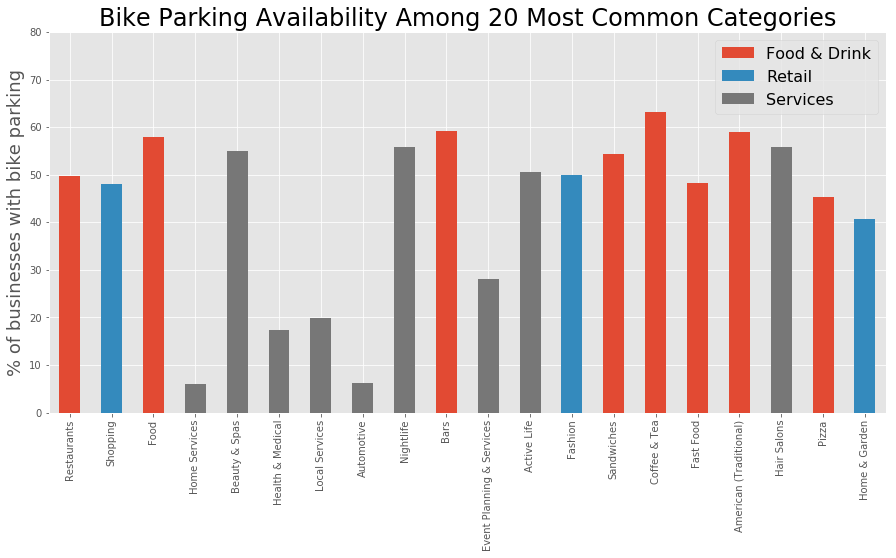

In [18]:
topcats.plot.bar(x='category', y='prop_bike_parking', color=colors)


plt.title("Bike Parking Availability Among 20 Most Common Categories", fontsize=24)
plt.ylabel("% of businesses with bike parking", fontsize=18)
plt.xlabel("")
plt.ylim(0, 80)
plt.legend(handles=legend_elements, fontsize=16)
plt.show()

We can see that generally, about 40-60% of the businesses in each category among this top 20 list have bike parking available, with the exception of a few services categories which have noticeably lower proportions.

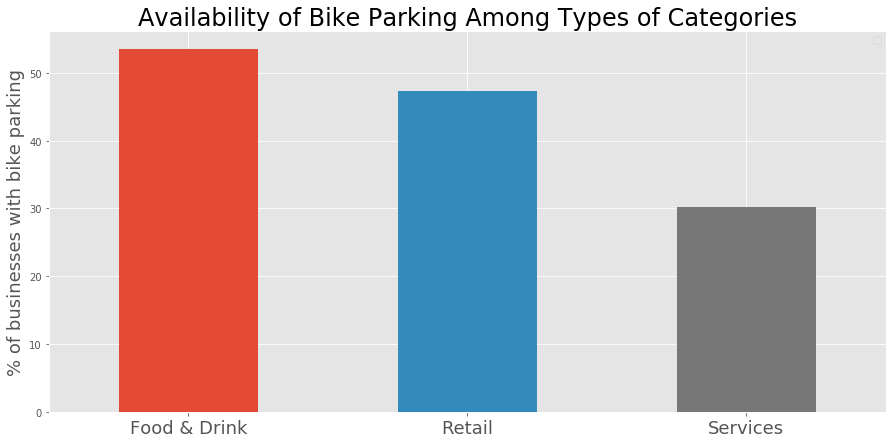

In [19]:
# df is the dataframe from the end of the previous section where we looked at our 3 generalized categories
df['prop_bike_parking'] = df.apply(lambda row: 100*row.bike_parking/row['count'], axis=1)

df.plot.bar(x='cat', y='prop_bike_parking', color=['C0','C1','C3'])


plt.xticks(rotation=0, fontsize=18)
plt.xlabel("")
plt.ylabel("% of businesses with bike parking", fontsize=18)
plt.title("Availability of Bike Parking Among Types of Categories", fontsize=24)
plt.legend("")
plt.show()

Looking at our simplified types, we can see that bike parking is most common for food & drink businesses, over half of which have bike parking available, closely followed by retail businesses. Bike parking is less common among businesses falling in the services category.

When we start looking at the list of categories where bike parking is most or least common among the entire dataset, on both ends we get lots of categories with very few businesses recorded as having that category tag. This does not help us answer us the question of which types of businesses tend to have bike parking, so we will only look at categories that show up in the dataset at least 15 times. This cutoff is fairly arbitrary, but is still based on a bit of investigation into the data: as we will see, most categories in the following list have much more than 15 observations.

In [20]:
topbike = cats[cats['count'] >= 15].sort_values('prop_bike_parking', ascending=False)
topbike.prop_bike_parking = topbike.prop_bike_parking.round(1)
topbike.head(10)

category  count  bike_parking  prop_bike_parking
203             Beer Gardens     80            69               86.2
705        Basketball Courts     17            14               82.4
205  Bike Repair/Maintenance    284           233               82.0
786            Rock Climbing     33            27               81.8
697          Ethical Grocery     21            17               81.0
724           Used Bookstore     30            24               80.0
670            Vinyl Records    140           112               80.0
466          Mountain Biking     82            65               79.3
734       Threading Services    279           220               78.9
561             Whiskey Bars     50            39               78.0

Above are shown the business categories where bike parking is most common. This list consists of businesses focused on serving alcohol, businesses providing bike services, businesses that provide active lifestyle services (basketball courts, rock climbing), and also some businesses that don't belong to any of these categorizations, and don't really form a group among themselves either. 

We won't show this, but if we continue to go down the list, businesses serving alcohol, businesses providing bike services, and businesses providing active lifestyle services all show up frequently, so it seems that these types of categories tend to have bike parking most commonly. 

Intuitively, this makes a lot of sense. It's no surprise that businesses providing bike services have bike parking. People that use the active lifestyle services are likely very interested in biking to the locations of these services, so again it is no surprise that such businesses frequently offer bike parking.

Perhaps the only somewhat surprising insight is that businesses focused on serving alcohol are so high up the list. Riding a bike while intoxicated is illegal both in the US and in Canada, but it seems that this is not frowned upon as much as driving under the influence, so businesses provide bike parking to direct customers to choose what is considered the lesser of two evils if they really have to. This is a very subjective perspective, and could very much not be actual explanation behind it. Based on the data we have, it is impossible to actually explain this phenomenon.

There are 24 categories where at least 75% of businesses provide bike parking.

The bottom of the list is much more packed: there are 93 categories where not a single business falling into each category has bike parking available. Keep in mind that we are still looking at categories with at least 15 observations. There does not appear to be a common characteristic between these categories: they range from religious schools to car brokers. Perhaps the most general insight we can provide is that a lot of these businesses provide services, which matches what we noticed when looking at the most frequent categories.

When we look at the categories that have at least one business with bike parking, the bottom of the list consists of categories that have hundreds or thousands of observations, but only in one to three cases does such a business have bike parking. Again, this list generally consists of businesses providing services.

### Relationship Between Rating Count and Star Rating

We want to investigate whether having a greater review count leads to a better rating. Recall that each business' rating is given in the column `stars`, which ranges from ranges from 0-5 with a step of 0.5.

Let's plot our two columns on a scatterplot:

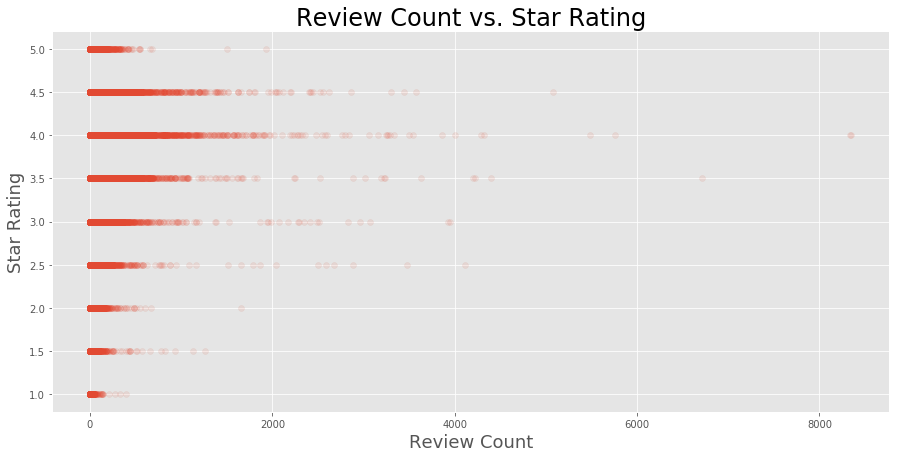

In [21]:
fig, ax = plt.subplots()

ax.scatter(x=business.review_count, y=business.stars, alpha=0.1)

plt.title("Review Count vs. Star Rating", fontsize=24)
plt.xlabel("Review Count", fontsize=18)
plt.ylabel("Star Rating", fontsize=18)
plt.show()

There are a lot of observations in our dataset, so we've made each point transparent to see the actual relationship between the variables. It does not seem like there is much going on, the data has a lot of variance, but we can still notice that higher ratings are more common for businesses with higher review counts.

We can fit a linear regression model to our data to get a more clear idea of the relationship.

In [22]:
# Create linear regression model
x = np.array(business.review_count).reshape((-1,1))
y = np.array(business.stars)
    
reg = LinearRegression().fit(x, y)

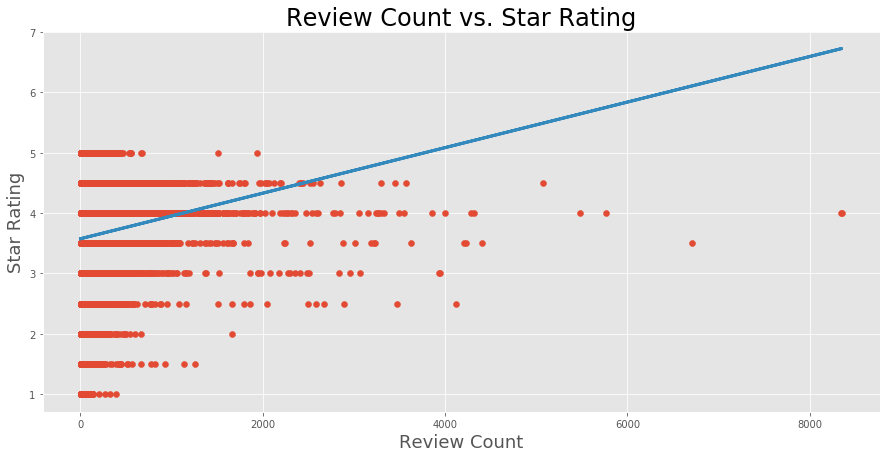

In [23]:
plt.scatter(x, y)
plt.plot(x, reg.predict(x),color='C1', linewidth=3)

plt.title("Review Count vs. Star Rating", fontsize=24)
plt.xlabel("Review Count", fontsize=18)
plt.ylabel("Star Rating", fontsize=18)
plt.show()

Whilst our linear regression model does show a positive relationship between the variables, even visually we can see that it does not fit the model well at all. This is confirmed by the model's $R^2$ value of 0.002, i.e. the model is able to explain only 0.2% of the variance in the data.

Hence we can fairly safely claim that there is no association between review count and star rating. The insight that higher ratings are more common for businesses with higher review counts is likely caused by how the ratings themselves distribute: most ratings fall in the 4.5-3 range.

# Businesses in the GTA

For this section we are interested in businesses situated in the Greater Toronto Area (GTA). People's definition of which municipalities are contained within the GTA varies, so we will be using the list of cities given in the relevant [Wikipedia article](https://en.wikipedia.org/wiki/Greater_Toronto_Area).

In [24]:
gta_cities = ['Toronto', 'Ajax', 'Clarington', 'Brock', 'Oshawa', 'Pickering', 'Scugog',
              'Uxbridge', 'Whitby', 'Burlington', 'Halton Hills', 'Milton', 'Oakville',
              'Brampton', 'Caledon', 'Mississauga', 'Aurora', 'East Gwilimbury', 'Georgina',
              'King', 'Markham', 'Newmarket', 'Richmond Hill', 'Vaughan', 'Whitchurch-Stouffville']

# We are checking the country too since the US and Canada share many city names
gta = business[(business.country == "Canada") & (business.city.isin(gta_cities))]

### Business Categories

We will take a look at what are the most popular business categories in the GTA, and compare it to our previous results regarding the entire dataset. To make comparisons easier, we will use the same methodology to classify our categories into three simpler ones: Food & Drink, Retail, and Services.

In [25]:
# We are also extracting information about the availability of bike parking per category,
# which we will need later. It is more efficient to do this here

keywords_gta = {}
# Iterate through df, extract category tag and bike parking availability counts
for i, bus in gta.iterrows():
    cat = bus.categories
    if cat is not None:
        for word in cat.split(','):
            if word.strip() in keywords_gta:
                keywords_gta[word.strip()] += 1
            else:
                keywords_gta[word.strip()] = 1

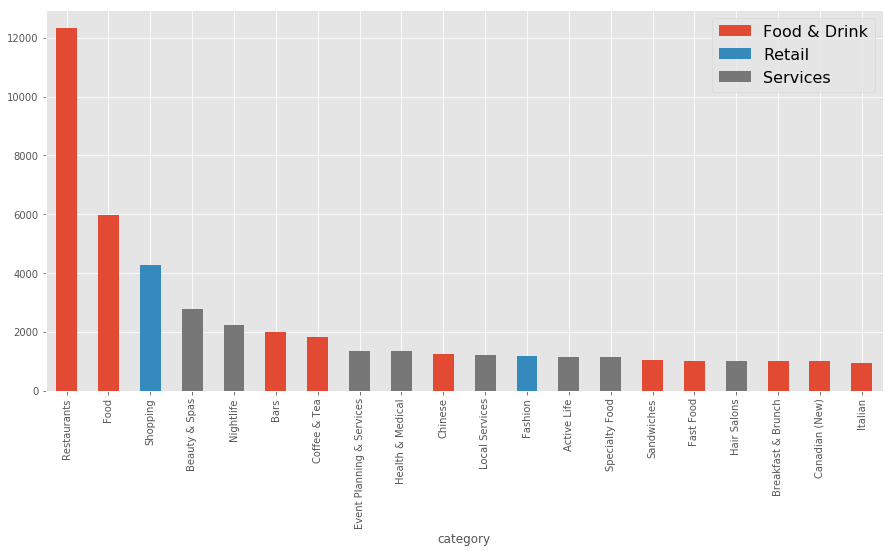

In [26]:
# Create new df containing top 20 categories based on count, and the number and proportion of such businesses
# that have bike parking available
cats = pd.DataFrame.from_dict(keywords_gta, orient='index')
cats = cats.reset_index()
cats.columns = ['category', 'count']
topcats_gta = cats.sort_values('count', ascending=False).head(20)
topcats_gta['simple_cat'] = topcats_gta.apply(lambda row: get_simple_category(row), axis=1)

# Decide on bar color based on simple_cat. Skipping 'C2' for better contrast
color_dict = {'Food & Drink': 'C0', 'Retail': 'C1', 'Services': 'C3'}
colors = [color_dict[cat] for cat in topcats_gta.simple_cat]

topcats_gta.plot.bar(x='category', y='count', label='', color=colors)

# Create custom legend based on our colormapping
legend_elements = [Patch(facecolor='C0', label='Food & Drink'),
                  Patch(facecolor='C1', label='Retail'),
                  Patch(facecolor='C3', label='Services')]
plt.legend(handles=legend_elements, fontsize=16)

plt.show()

At first glance this distribution looks fairly similar to what we saw previously with the entire dataset included, but when we take a closer look we start to notice differences. Let's place this visualization side-by-side with the equivalent graph for the entire dataset for better comparison:

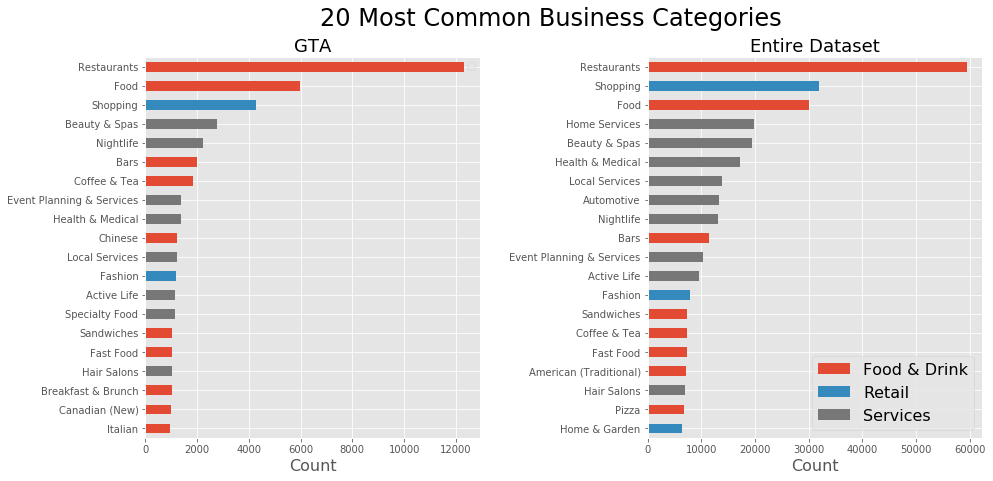

In [27]:
fig, ax = plt.subplots(1,2)

# Decide on bar color based on simple_cat. Skipping 'C2' for better contrast
color_dict = {'Food & Drink': 'C0', 'Retail': 'C1', 'Services': 'C3'}
colors_gta = [color_dict[cat] for cat in topcats_gta.simple_cat]
colors = [color_dict[cat] for cat in topcats.simple_cat]

topcats_gta.plot.barh(x='category', y='count', ax=ax[0], label='', color=colors_gta)

topcats.plot.barh(x='category', y='count', ax=ax[1], label='', color=colors)



ax[0].invert_yaxis()
ax[1].invert_yaxis()
ax[0].set_ylabel("")
ax[1].set_ylabel("")
ax[0].set_xlabel("Count", fontsize=16)
ax[1].set_xlabel("Count", fontsize=16)

ax[0].set_title("GTA", fontsize=18)
ax[1].set_title("Entire Dataset", fontsize=18)
ax[0].legend("")

# Create custom legend based on our colormapping
legend_elements = [Patch(facecolor='C0', label='Food & Drink'),
                  Patch(facecolor='C1', label='Retail'),
                  Patch(facecolor='C3', label='Services')]
plt.legend(handles=legend_elements, fontsize=16)

plt.suptitle("20 Most Common Business Categories", fontsize=24)
plt.subplots_adjust(wspace=0.5)
plt.show()

Of course, count-wise the numbers are much greater when the entire dataset is included. Restaurants, Food, and Shopping are the 3 most common categories in both datasets. Home Services, the 4th most popular category in the entire dataset is not even present in the GTA top 20 list. In the overall list, American (Traditional) is the only category referring to cuisine from a certain country or ethnicity, but in the GTA dataset there are multiple such categories: Chinese, Canadian (New), and Italian.

Let's also see how the three simple categories compare across the entire dataset and its subset in terms of proportions:

In [28]:
# Get total counts per simple_cat and create new df
d_gta = {'Food & Drink':0, "Retail":0, "Services":0}
for i, row in topcats_gta.iterrows():
    d_gta[row.simple_cat] += row['count']
    
df_gta = pd.DataFrame.from_dict(d_gta, orient='index')
df_gta = df_gta.reset_index()
df_gta.columns = ['cat', 'count']

In [29]:
# Find count sum for categories within top 20 lists
total = df['count'].sum()
total_gta = df_gta['count'].sum()
# Find proportion of simple categories within top 20 lists
cat_prop = df['count'] / total
cat_prop_gta = df_gta['count'] / total_gta

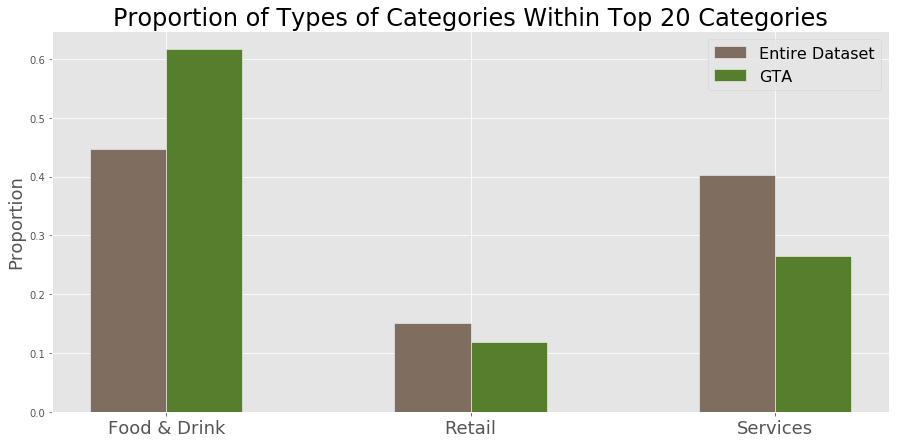

In [30]:
width=0.25
r1= np.arange(len(df))
r2= [x + width for x in r1]

plt.bar(r1, cat_prop, color='#7f6d5f', width=width, edgecolor='white', label='Entire Dataset')
plt.bar(r2, cat_prop_gta, color='#557f2d', width=width, edgecolor='white', label='GTA')

plt.xticks(r1 + width / 2, ['Food & Drink', 'Retail', 'Services'], rotation=0, fontsize=18)
plt.xlabel("")
plt.ylabel("Proportion", fontsize=18)
plt.title("Proportion of Types of Categories Within Top 20 Categories", fontsize=24)
plt.legend(fontsize=16)
plt.show()

We can see that Food & Drink categories make up a much greater proportion in the GTA than in the entire dataset, and this mainly comes from Services categories having a noticeably lower propotion. Just like in the overall case, retail categories make up the smallest proportion of categories.

### Top Franchises in the GTA

We would like to know what are the most common franchises in the GTA. Before we can start this analysis, we realise that the same issue we had with city names shows up again - there are inconsistencies in business names. For example, both "Tim Hortons" and "Tim Horton's" are present in the dataset.

Again, we will use Fuzzywuzzy to fix this, but we will only do so for the 20 most popular business names before any sort of corrections. While it is possible that if we fixed all business names the top 20 list would change, a quick glimpse into the data shows that it would only affect the tail of the list, if at all. This is necessary for reasonable computing times.

There is one exception to this: we will exclude Pizza Pizza from being fixed. Because lots of pizza restaurants have "Pizza" in their names, they will frequently get matched with "Pizza Pizza". This means that potentially Pizza Pizza could be higher up the list, but we don't have an easy way of fixing this unless we had more computing power for a more exhaustive string correction method.

In [31]:
# Names for top 20 businesses, excluding Pizza Pizza
names = list(gta['name'].value_counts().head(20).index).copy()
names.remove('Pizza Pizza')

def fix_business_name(row: pd.Series) -> str:
    """Given a Pandas Series representing a row about a business,
       returns the fuzzy corrected business name."""
    bus = row['name']
    cutoff = 90
    
    # Pizza Pizza is problematic, so we will not fix it
    if bus == 'Pizza Pizza':
        return bus
    
    # If we get a match of >= cutoff %, return that match.
    # Otherwise, return the original business name.
    for name in names:
        if fuzz.token_set_ratio(bus, name) >= cutoff:
            return name
    return bus

gta['name'] = gta.apply(lambda row: fix_business_name(row), axis=1)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


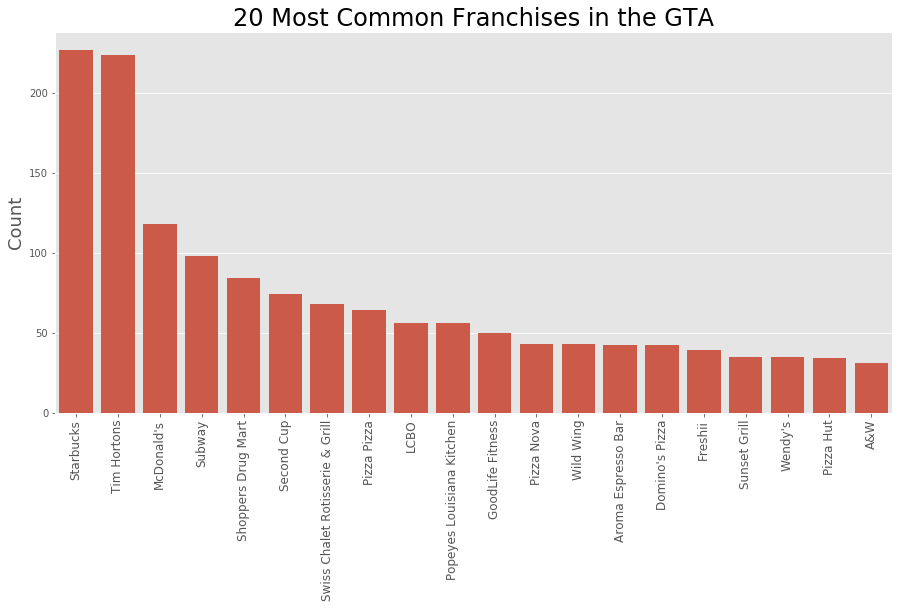

In [32]:
sns.countplot(gta.name, order=gta.name.value_counts().iloc[:20].index, color='C0')

plt.xticks(rotation=90)
plt.title("20 Most Common Franchises in the GTA", fontsize=24)
plt.ylabel("Count", fontsize=18)
plt.xlabel("")
plt.xticks(fontsize=12)

plt.show()

As we saw previously, most businesses in the GTA were in the food and drink industry, so it is no surprise that this top 20 list consists of businesses in that industry. Only two businesses, GoodLife Fitness and Shoppers Drug Mart, do not belong to this industry. Starbucks and Tim Hortons are the two big chains that have about double the locations than those that follow them in ranking.

### Effect of Business Location on Reviews

We would like to analyse whether the location of a business can affect their reviews: namely, we will look at if business location can affect the star rating and the number of reviews a business gets.

Before we jump into those questions, let's take a look at how the businesses in our GTA dataset are located. There are a lot of observations in the data, so a simple point plot would not work: everything would just be really cluttered. Instead, we want to use our points to define areas that are similar to each other, and then see what we can find out about each area. 

To do this, we will use [Quadtree plots](https://residentmario.github.io/geoplot/plot_references/plot_reference.html#quadtree) that come as a part of the [geoplot](https://residentmario.github.io/geoplot/index.html) Python package. In this case, this algorithm creates rectangles that contain no more than 5 businesses each by recursively dividing the space our businesses are located on.

In [33]:
# Create GeoDataFrame for businesses in the GTA
gdf_gta = gpd.GeoDataFrame(
    gta, geometry=gpd.points_from_xy(gta.longitude, gta.latitude), crs=world.crs)
gdf_gta = gdf_gta.to_crs(epsg=3857)

Before we can create these plots, we have to adjust our data a bit. For some reason, the coordinates provided in the dataset have an [extreme degree of precision](https://xkcd.com/2170/), which means that on the scale the quadtree algorithm operates on, many points fall on the same location and hence cause the algorithm to fail since it cannot divide the entire area into the rectangles we desire.

Thus, we will need to "jitter" the points. That is, we will adjust all points in our dataset by a tiny random amount. This will, of course, introduce some imprecision, but it is on a scale of centimeters - unnoticeable for the scale we are doing our analysis on.

In [34]:
def rand_jitter(arr: pd.Series) -> pd.Series:
    """Given a Series of values, jitter the values randomly and return
    the jittered series.
    
    Adapted from https://stackoverflow.com/questions/8671808/matplotlib-avoiding-overlapping-datapoints-in-a-scatter-dot-beeswarm-plot
    """
    stdev = .0001*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

def jitter_coords(x_col: pd.Series, y_col: pd.Series) -> Tuple[pd.Series]:
    """Given Pandas Series representing the longitude and latitude coordinates
    present in the dataset, jitter both columns and test if the jittering was
    successful. Return the jittered columns"""
    x_col = rand_jitter(x_col)
    y_col = rand_jitter(y_col)
    
    # Check that we no longer have two points with the same coordinates
    regroup_sizes = (
            pd.DataFrame()
            .assign(x=x_col, y=y_col)
            .groupby(['x', 'y'])
            .size()
        )
    assert not (regroup_sizes > 1).any()
    
    return (x_col, y_col)

# Jitter columns and create new Point objects
new_x, new_y = jitter_coords(gdf_gta.longitude, gdf_gta.latitude)
for i, row in gdf_gta.iterrows():
    gdf_gta.loc[i, 'geometry'] = Point(new_x[i], new_y[i])

Now, we can finally create our quadtree plot.

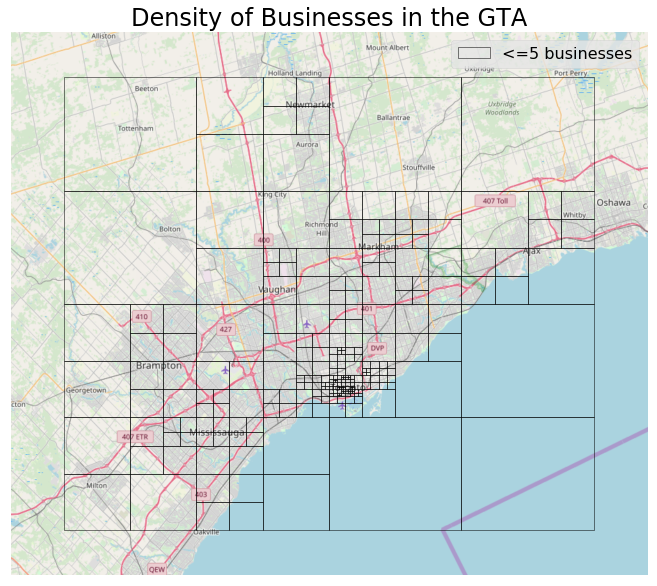

In [38]:
ax = gplt.quadtree(gdf_gta, edgecolor='black', nmax=5,
                   projection=gcrs.WebMercator(), figsize=(15,10))
gplt.webmap(gdf_gta, projection=gcrs.WebMercator(), ax=ax)


legend_elements = [Patch(edgecolor='black', fill=False, label='<=5 businesses')]
plt.legend(handles=legend_elements, fontsize=16)

plt.title("Density of Businesses in the GTA", fontsize=24)
plt.show()

Recall, that each rectangle contains at most 5 businesses from our dataset. Thus, these rectangles visualize density really well: clusters of small rectangles such as in the downtown Toronto area show that there are a lot of businesses in that region. Markham and Mississauga are the other locations where businesses are densely packed.

Immediately one should notice that we have also created some rectangles entirely inside Lake Ontario. This, of course, does not mean that there are businesses there, but since this algorithm starts from a large rectangle bounding all of the points and then divides it down, as a byproduct we are also left with some rectangles that don't have any businesses within them. This can also be the case for some of the other rectangles that are on the edges of the big rectangle.

So, as we proceed with this analysis it is important to keep in mind that not all rectangles actually represent information about businesses. Because we are using an open-source package for these visualizations, the package does not have a way of avoiding this, and no alternative methods exist. Really large rectangles should be a warning that they may contain one or no businesses.

Now that we have divided the GTA into these rectangles, we can give them a hue based on the data we care about. First, let's colour each rectangle based on the average star rating of the businesses within them:

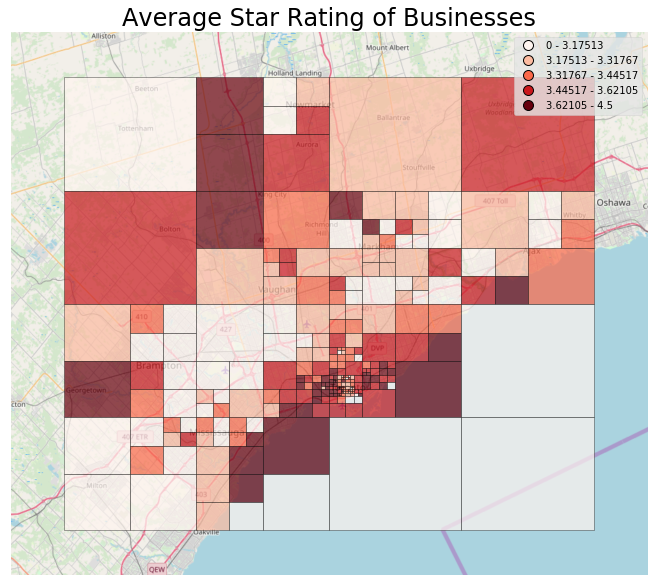

In [39]:
ax = gplt.quadtree(gdf_gta, edgecolor='black', nmax=5,
                   hue='stars', cmap='Reds', alpha=0.7, scheme='Quantiles',
                   projection=gcrs.WebMercator(), figsize=(15,10), legend=True)
gplt.webmap(gdf_gta, projection=gcrs.WebMercator(), ax=ax)

plt.title("Average Star Rating of Businesses", fontsize=24)
plt.show()

Rather than a gradual scale, we have coloured the rectangles by 20% quantiles since most businesses have a rating in the 3-4 range. We can really easily see that businesses in downtown Toronto and businesses along the coast of Lake Ontario have greater ratings on average than elsewhere. Also, some businesses to the west of King City along highway 400 have really high ratings on average.

Recall our discussion about rectangles that may not contain any businesses: this is likely the case for most rectangles that have the lowest average rating value - a lot of these rectangles fall outside of our area of study or on areas that consist largely of highways. Of course, it is possible that in some of these cases there actually are businesses with a really low average rating. Again, we are unfortunately limited by the tools available to us - we don't have a way to ignore the rectangles that don't actually hold any value to us.

We can also follow the same methodology for review count:

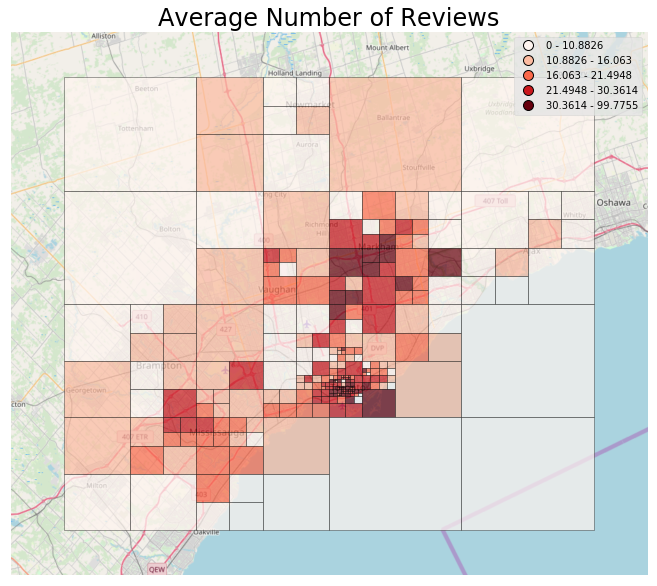

In [40]:
ax = gplt.quadtree(gdf_gta, edgecolor='black', nmax=5,
                   hue='review_count', cmap='Reds', alpha=0.7, scheme='Quantiles',
                   projection=gcrs.WebMercator(), figsize=(15,10), legend=True)
gplt.webmap(gdf_gta, projection=gcrs.WebMercator(), ax=ax)

plt.title("Average Number of Reviews", fontsize=24)
plt.show()

Businesses in the downtown Toronto and Markham areas tend to have more reviews than elsewhere on average. Reviews are also frequent for businesses located in Mississauga and Vaughan.

If we cross-examine the rectangles with very few reviews with those with really low average ratings, we can make a good guess on which of them contain no businesses - as hypothesised, it appears that these are mostly businesses on the edges of the big rectangle.

### Tim Hortons and Starbucks

When we analysed the most common franchises in the GTA, we saw that this list was dominated by the two coffee giants Tim Hortons and Starbucks. In fact, it seems that whereever you walk, these two chains are always around every corner, and nearly always they are located right next to each other. We would like to investigate whether this is an actual phenomenon or just the product of confirmation bias.

To do so, we can compute the distance between every Tim Hortons location and their closest Starbucks neighbour. Since our dataset contains spherical coordinates, we can use the [Haversine formula](https://en.wikipedia.org/wiki/Haversine_formula) to compute these distances.

In [71]:
# Create DataFrame and GeoDataFrame for Tim Hortons and Starbucks locations
coffee = gta[(gta['name'] == 'Tim Hortons') | (gta['name'] == 'Starbucks')]
gdf_coffee = gdf_gta[(gdf_gta['name'] == 'Tim Hortons') | (gdf_gta['name'] == 'Starbucks')]

# Create DataFrame separately for Tim Hortons and Starbucks
starbucks = gta[gta['name'] == 'Starbucks']
tims = gta[gta['name'] == 'Tim Hortons']

In [72]:
def get_closest_neighbour(row: pd.Series, reference: pd.DataFrame) -> float:
    """Given a Pandas Series representing a row about a business, finds the
    distance in meters to the closest point in the reference data w.r.t.
    this business using the Haversine method.
    """
    coords = (row.longitude, row.latitude)
    min_dist = float("inf")
    # Compute distance for each point in reference
    for i, ref in reference.iterrows():
        ref_coords = (ref.longitude, ref.latitude)
        dist = haversine(coords, ref_coords, unit=Unit.METERS)
        if dist < min_dist:
            min_dist = dist
            
    # Make sure min_dist isn't infinite
    assert min_dist < float("inf")
    return min_dist

tims['closest_star'] = tims.apply(lambda row: get_closest_neighbour(row, starbucks), axis=1)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


We can visualize the distribution of these distances on a histogram:

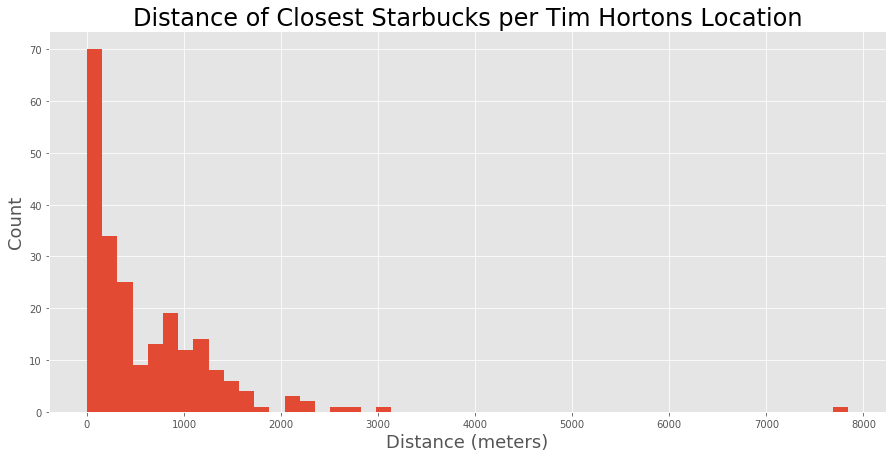

In [73]:
fig, ax = plt.subplots()

ax.hist(x=tims.closest_star, bins=50)

plt.title("Distance of Closest Starbucks per Tim Hortons Location", fontsize=24)
plt.xlabel("Distance (meters)", fontsize=18)
plt.ylabel("Count", fontsize=18)
plt.show()

In [74]:
desc = {"Distance of Closest Starbucks (meters)": tims.closest_star.describe().round(1)}
pd.DataFrame(desc)

Distance of Closest Starbucks (meters)
count                                   224.0
mean                                    609.3
std                                     760.9
min                                       0.0
25%                                     113.3
50%                                     351.3
75%                                     919.7
max                                    7838.8

Of course the definition of "right next to" is subjective, but it certainly does not seem like every Tim Hortons has a Starbucks right next to it. Only in less than 25% of the cases is there a Starbucks within a 100m radius from a Tim Hortons location. On average, the distance between the two chains is just over 600 meters. In a curious outlying case, a Tim Hortons location is nearly 8km away from its closest neighbouring Starbucks.



In [75]:
# Create GeoDataFrames for Starbucks and Tim Hortons
gdf_star = gpd.GeoDataFrame(starbucks, geometry='geometry', crs=world.crs)
gdf_tims = gpd.GeoDataFrame(tims, geometry='geometry', crs=world.crs)

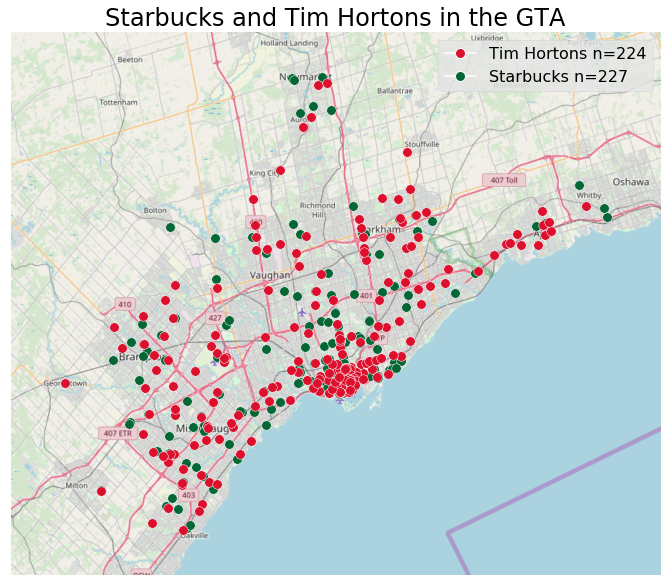

In [80]:
temp_star = gdf_star.to_crs(epsg=3857)
temp_tims = gdf_tims.to_crs(epsg=3857)

# Thematic colors for Tim Hortons and Starbucks
colors = ['#dc0f2d', '#036635']

ax = gplt.webmap(gdf_coffee, projection=gcrs.WebMercator(), figsize=(15,10))
temp_star.plot(ax=ax, color=colors[1], edgecolor='white', markersize=90)
temp_tims.plot(ax=ax, color=colors[0], edgecolor='white', markersize=90)

points = [Line2D([0],[0], marker='o', color='white', label='Tim Hortons n={}'.format(len(temp_tims.index)),
                 markerfacecolor=colors[0], markersize=10),
         Line2D([0],[0], marker='o', color='white', label='Starbucks n={}'.format(len(temp_star.index)),
                 markerfacecolor=colors[1], markersize=10),]

plt.title("Starbucks and Tim Hortons in the GTA", fontsize=24)
plt.legend(handles=points, fontsize=16)
plt.show()

When we visualize our coffee shops on a map we can come up with an explanation for why the distance distribution is bimodal: the competing shops are really close together in downtown areas, and further apart outside of them.

Surely there are a lot of factors that are taken into consideration when these chains choose the locations for their shops. Since these chains are the two most common businesses in the GTA and they operate in the exact same industry, it is reasonable to say that Tim Hortons and Starbucks are each other's main competitors, and as such the way they choose the locations for their shop should depend on how their competitor does it.

So naturally, it would be interesting to see if there's a way we can measure which of these two companies has been more successful in choosing their locations. "Success" is another very vague term. We certainly don't have the data on how much revenue or profit each shop generates, but perhaps there is a way to measure "success" spatially.

Consider this: the businesses are located in the GTA, our area of interest. Every Tim Hortons shop's main competitors are the Starbucks locations closest to it. Hence, if we could somehow divide the GTA into smaller areas based on clusters of Tim Hortons locations and the Starbucks shops right around them, we could analyse which chain is dominant in each such area by counting the number of shops each chain has.

We will achieve exactly this by using [Thiessen (Voronoi) polygons](https://en.wikipedia.org/wiki/Voronoi_diagram). We will create a Thiessen polygon for each Tim Hortons location in our dataset, which means that for every such polygon, any other point (a Starbucks location, for example) in this polygon is guaranteed to be closest to the Tim Hortons the polygon was created for.

The algorithm for generating such polygons is quite complicated, but thankfully we can compute them using the Voronoi tool in the SciPy package, and even visualize them using geoplot:

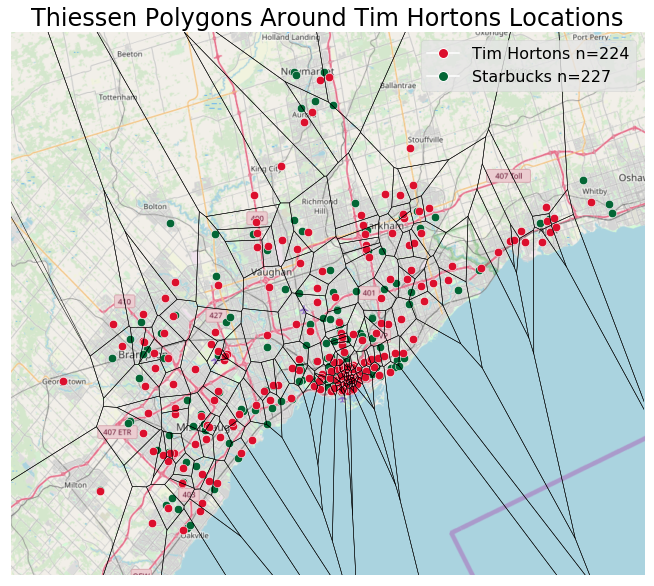

In [83]:
ax = gplt.webmap(gdf_coffee, projection=gcrs.WebMercator(), figsize=(15,10))
gplt.voronoi(gdf_tims, ax=ax)
temp_star.plot(ax=ax, color=colors[1], edgecolor='white', markersize=70)
temp_tims.plot(ax=ax, color=colors[0], edgecolor='white', markersize=70)

points = [Line2D([0],[0], marker='o', color='white', label='Tim Hortons n={}'.format(len(temp_tims.index)),
                 markerfacecolor=colors[0], markersize=10),
         Line2D([0],[0], marker='o', color='white', label='Starbucks n={}'.format(len(temp_star.index)),
                 markerfacecolor=colors[1], markersize=10),]

plt.title("Thiessen Polygons Around Tim Hortons Locations", fontsize=24)
plt.legend(handles=points, fontsize=16)
plt.show()

Besides helping us understand the concept, visualizing Thiessen polygons does not help us much. Convince yourself that each polygon has just a single Tim Hortons location, and that any Starbucks within a polygon is closer to that Tim Hortons location than to any other.

Also notice the polygons on the edges of the map - since there are no further Tim Hortons locations, these polygons are infinite in size. We will attempt to fix this by manually bounding the polygons, but this will not be perfect: unless we traced the exact city boundaries, it is difficult to decide where the boundaries of the GTA lie. Furthermore, some of the polygons extend into Lake Ontario, which we certainly don't want to take into account. Again, we will attempt to bound the polygons, but we will still capture the lake in many cases. We could fix these issues more successfully if we had access to specialized and optimized geographic information system (GIS) software, but due to the free Python software we are using this level of error will have to suffice.

In [84]:
# Extract coordinates of Tim Hortons locations as tuples so we can create a Voronoi object
points = []
for i, row in tims.iterrows():
    points.append((row.longitude, row.latitude))

# Outer Voronoi polygons are infinite in size, so we add 6 new points to bound as many as reasonably
# possible in finite polygons.
# We look at the max and min x,y values for the coordinates of Tim Hortons locations, and generate
# points that are slightly further out.
# Note that these new points are not taken into account in the analysis that follows
edges = gdf_tims.total_bounds
points.append((edges[0]-0.01, edges[1]-0.01))
points.append((edges[0]-0.01, edges[3]+0.01))
points.append((edges[2]+0.01, edges[1]-0.01))
points.append((edges[2]+0.01, edges[3]+0.01))
points.append(((edges[0]+edges[2])/2, edges[1]-0.01))
points.append(((edges[0]+edges[2])/2, edges[3]+0.01))
points.append(((edges[0]-0.01, (edges[1] + edges[3])/2)))
points.append(((edges[2]+0.01, (edges[1] + edges[3])/2)))

# Create Voronoi object
vor = scp.spatial.Voronoi(points=points)

In [85]:
# Get the boundaries of finite polygons. Infinite polygons have a -1 entry in them.
lines = [
    LineString(vor.vertices[line])
    for line in vor.ridge_vertices
    if -1 not in line
]
# Create polygons based on lines, create DataFrame out of polygons
polygons = [pol for pol in polygonize(lines)]
pol_df = pd.DataFrame(polygons)
pol_df.columns=['polygon']

We have created a dataframe where each row corresponds to a polygon. We have not included any polygons that are infinite in size; after our corrections very few valid polygons had to be removed. We will count the number of Starbucks locations in each polygon, and compute the area size for each polygon, and add these statistics to the dataframe.

Recall that the coordinate data in our dataset was given in spherical coordinates - this does not work when computing areas. Hence, we will project our polygons using the Albers Equal Area conic projection - a projection that preserves size, and is designed to be used for locations in temperate areas such as Canada. Projections that maintain size distort shape, but this is not a problem for our analysis since each Starbucks is still contained within the same polygon as before, only visually would it look different.

In [86]:
def get_n_starbucks(row: pd.Series) -> int:
    """Given a Pandas Series representing a row about a Thiessen polygon, return the
    number of Starbucks locations within it."""
    n_star = 0
    for i, star in starbucks.iterrows():
        if star.geometry.within(row.polygon):
            n_star += 1
    return n_star

def get_poly_area(row: pd.Series) -> int:
    """Given a Pandas Series representing a row about a Thiessen polygon,
    return the area size of the polygon using the Albers Equal Area conic projection"""
    polygon = row.polygon
    # Project polygon
    geom_area = ops.transform(
    partial(
    pyproj.transform,
    pyproj.Proj(init='EPSG:4326'),
    pyproj.Proj(
        proj='aea',
        lat1=polygon.bounds[1],
        lat2=polygon.bounds[3], preserve_units=True)),
    polygon) 
    return geom_area.area

pol_df['n_starbucks'] = pol_df.apply(lambda row: get_n_starbucks(row), axis=1)
pol_df['area_m2'] = pol_df.apply(lambda row: get_poly_area(row), axis=1)

We can now visualize the number of Starbucks locations within our polygons using a barplot:

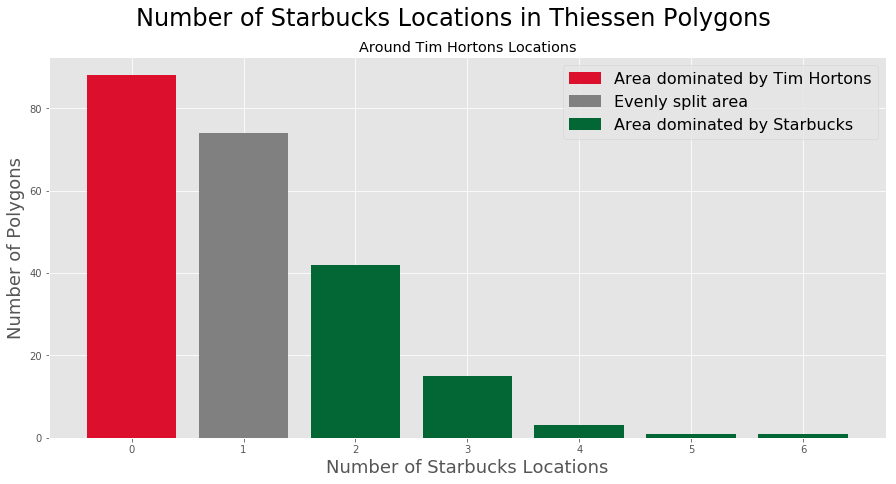

In [93]:
# Group polygons based on the number of Starbucks they contain
count_n = pol_df.groupby('n_starbucks').count()

fig, ax = plt.subplots()
ax = plt.bar(x=count_n.index, height=count_n.polygon,
             color=(colors[0], 'gray', colors[1], colors[1], colors[1], colors[1], colors[1]))

legend_elements= [Patch(facecolor=colors[0], label='Area dominated by Tim Hortons'),
                  Patch(facecolor='gray', label = 'Evenly split area'),
                  Patch(facecolor=colors[1], label = 'Area dominated by Starbucks')]

plt.legend(handles=legend_elements, fontsize=16)    

plt.suptitle("Number of Starbucks Locations in Thiessen Polygons", fontsize=24)
plt.title("Around Tim Hortons Locations")
plt.xlabel("Number of Starbucks Locations", fontsize=18)
plt.ylabel("Number of Polygons", fontsize=18)
plt.xticks([0,1,2,3,4,5,6])
plt.show()

We have grouped the polygons based on the number of Starbucks locations they contain. If there are no Starbucks locations in a polygon, it means that the Tim Hortons shop within it "has the entire area to themselves". If there is one Starbucks in a polygon, the area is split evenly. If there are more than one, it means that area is dominated by Starbucks.

Most Tim Hortons locations are situated in a way that they get to dominate their polygon, or have split the area evenly with Starbucks. This is favourable for Tim Hortons, since it means that other Tim Hortons locations deal with the competing Starbucks shops, and these Tim Hortons shops can operate more freely in their polygon. In fewer cases is there a situation such that Starbucks dominates in the area, and in most such cases Starbucks only dominates by one or two shops.

However, this sort of counting does not give us the entire picture. Sure, Tim Hortons dominates in more areas, but the properties of the areas involved matter too. Dominating in an area of greater size is more valuable because it is likely to capture more people - potential customers. Hence, we should look at the average sizes of the polygons involved.

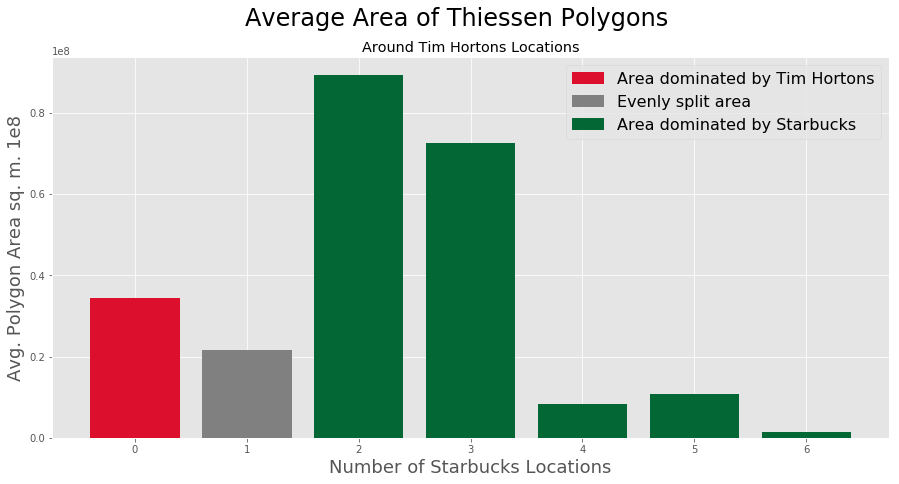

In [95]:
mean_area = pol_df.groupby('n_starbucks').mean().reset_index()

ax = plt.bar(x=mean_area.index, height=mean_area.area_m2,
             color=(colors[0], 'gray', colors[1], colors[1], colors[1], colors[1], colors[1]))

legend_elements= [Patch(facecolor=colors[0], label='Area dominated by Tim Hortons'),
                  Patch(facecolor='gray', label = 'Evenly split area'),
                  Patch(facecolor=colors[1], label = 'Area dominated by Starbucks')]

plt.legend(handles=legend_elements, fontsize=16)

plt.suptitle("Average Area of Thiessen Polygons", fontsize=24)
plt.title("Around Tim Hortons Locations")
plt.xlabel("Number of Starbucks Locations", fontsize=18)
plt.ylabel("Avg. Polygon Area sq. m. 1e8", fontsize=18)
plt.show()

Immediately we notice a different pattern: the average sizes of the polygons where Starbucks shops dominate are significantly greater than the sizes of polygons where Tim Hortons dominates. The areas where Starbucks dominates by 3 or more shops are on average small in size: these are probably polygons in downtown areas.

Finally, we should look at the summed areas these polygons cover:

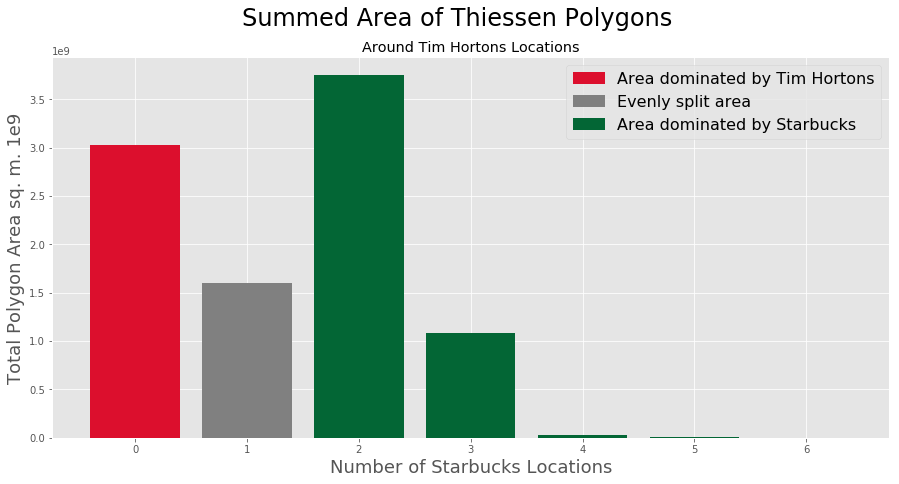

In [96]:
sum_area = pol_df.groupby('n_starbucks').sum().reset_index()

ax = plt.bar(x=sum_area.index, height=sum_area.area_m2,
             color=(colors[0], 'gray', colors[1], colors[1], colors[1], colors[1], colors[1]))

legend_elements= [Patch(facecolor=colors[0], label='Area dominated by Tim Hortons'),
                  Patch(facecolor='gray', label = 'Evenly split area'),
                  Patch(facecolor=colors[1], label = 'Area dominated by Starbucks')]

plt.legend(handles=legend_elements, fontsize=16)

plt.suptitle("Summed Area of Thiessen Polygons", fontsize=24)
plt.title("Around Tim Hortons Locations")
plt.xlabel("Number of Starbucks Locations", fontsize=18)
plt.ylabel("Total Polygon Area sq. m. 1e9", fontsize=18)
plt.show()

We see that even though Tim Hortons has placed their locations so that they have more polygons to themselves, the total areas of the polygons show that Starbucks has the upper hand. This domination is certainly not crushing for Tim Hortons, since in the large majority of cases Starbucks only dominates by a shop or two.

Remember our initial motivation for this methodology: we wanted to split up the GTA into smaller areas. If we summed up the bars in this visualization we would get the entire area size for our area of interest. This means that Starbucks has placed their shops relative to Tim Hortons locations in a way that allows them to dominate in most of the GTA.

Thiessen polygons can be a very powerful tool. Recall that these polygons mean that any location within this polygon is guaranteed to be closest to the point we created the polygon around. If we assume that people are rational beings (which is certainly a bold assumption), it is very likely that a person decides which coffee shop to visit based on the polygon they are situated in. This is why the dominance we described can be ever so valuable.

There are so many ways to branch out this analysis. For example, if we combined our polygon data with population, income, or commute data, we could evaluate how many people a polygon is likely to capture, and how valuable these people could be in terms of the revenue they can generate. Or instead, if we could analyse the road infrastructure and accessibility of each polygon, we could see where coffee shops are most convenient to visit - the business model of these coffee chains is to serve people as quickly as possible, and many customers take their beverages with them instead of staying in the shop.

It should also be noted that our choice to create the polygons around Tim Hortons shops was arbitrary. Since the number of Tim Hortons and Starbucks locations is nearly the exact same, we would expect the results of this analysis to be the same if we created our polygons around Starbucks locations instead.

# Business Reviews

### User Review Frequency

We would like to analyse whether a small group of users is responsible for the majority of reviews.

In [136]:
# Group reviews by user IDs to see how many reviews each user has written.
# Then, group the table by the number of reviews users have made
review_per_user = review.groupby('user_id').count().groupby('review_id')
review_per_user = review_per_user.count().iloc[:,1].to_frame()
review_per_user = review_per_user.reset_index()
review_per_user.columns = ['n_reviews', 'count']

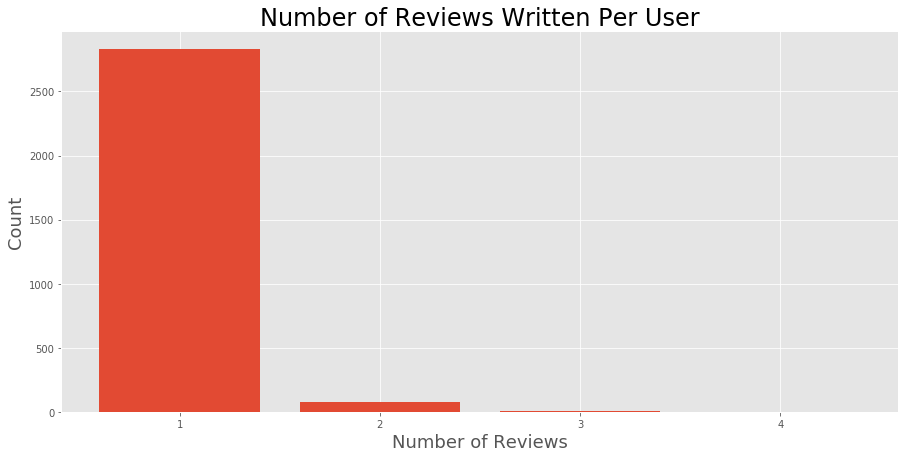

In [135]:
fig, ax = plt.subplots()

ax.bar(x=review_per_user['n_reviews'], height=review_per_user['count'])

plt.xticks(np.arange(len(review_per_user)) + 1, review_per_user.n_reviews)
plt.title("Number of Reviews Written Per User", fontsize=24)
plt.xlabel("Number of Reviews", fontsize=18)
plt.ylabel("Count", fontsize=18)
plt.show()

### Language Use in Reviews for Tim Hortons and Starbucks


In [138]:
tims.head()

business_id         name               address       city  \
506   jdgkNUgWTZ4_vqVHHqFk6g  Tim Hortons     1750 Bayly Street  Pickering   
3550  uovoaLJV99NdPRgv43sLFQ  Tim Hortons  370 Steeles Avenue W    Vaughan   
4839  Ai4n7V09AEvMHVbY_6bCoA  Tim Hortons    733 Kipling Avenue    Toronto   
5816  2reVz4qVRTR8oRgl9lF4aA  Tim Hortons   1600 Langstaff Road    Vaughan   
6162  2ZCNWSfOacFASdVR99EuYg  Tim Hortons       2 Bruyeres Mews    Toronto   

     state postal_code   latitude  longitude  stars  review_count  is_open  \
506     ON     L1W 3N3  43.833891 -79.064991    1.5             3        1   
3550    ON     L4J 6X1  43.795676 -79.433401    2.0             7        1   
4839    ON     M8Z 5G5  43.626447 -79.528715    2.5             3        1   
5816    ON     L4K 1R8  43.824104 -79.478682    3.0             6        1   
6162    ON     M5V 0G7  43.637441 -79.400311    2.0             4        1   

                                             attributes  \
506   {'Caters': 'False', 'RestaurantsPriceRange2': ...   
3550  {'GoodForKids': 'True', 'RestaurantsReservatio...   
4839  {'BikeParking': 'True', 'Ambience': '{'romanti...   
5816  {'OutdoorSeating': 'False', 'BusinessParking':...   
6162  {'RestaurantsDelivery': 'False', 'RestaurantsT...   

                                            categories  \
506                                               Food   
3550  Food, Restaurants, Cafes, Bakeries, Coffee & Tea   
4839                                Restaurants, Cafes   
5816                                Food, Coffee & Tea   
6162                      Food, Coffee & Tea, Bakeries   

                                                  hours  \
506                                                None   
3550                                               None   
4839                                               None   
5816  {'Monday': '0:0-0:0', 'Tuesday': '0:0-0:0', 'W...   
6162  {'Monday': '7:0-23:0', 'Tuesday': '7:0-23:0', ...   

                        geometry country  closest_star  
506   POINT (-79.06499 43.83389)  Canada   2790.835983  
3550  POINT (-79.43340 43.79568)  Canada   1197.075555  
4839  POINT (-79.52871 43.62645)  Canada    417.343100  
5816  POINT (-79.47868 43.82410)  Canada   1001.311548  
6162  POINT (-79.40031 43.63744)  Canada     21.728594

In [186]:
# tims and starbucks are dataframes defined previously, containing Tim Hortons and Starbucks
# businesses in the GTA, respectively
tims_reviews = review[review.business_id.isin(tims.business_id)]
starbucks_reviews = review[review.business_id.isin(starbucks.business_id)]

In [231]:
tims_reviews

review_id                 user_id             business_id  \
3381  mTZvq_y1w1x2_q6QzeGjCA  oSL39s__owii0Me8u-OS9g  uovoaLJV99NdPRgv43sLFQ   
6587  xVDjrNWii51cdDn1U84MaQ  lR2zF-gSOEaNyZVdgDA5Gg  6756R6GyrhnQnxaB19kJtw   
8355  MjwHus6HVB6pPufdV3UzRQ  9ydq1GlwsUlEACfhL5XLog  uovoaLJV99NdPRgv43sLFQ   
8436  bAgw7lPeZdFMw3z5alm6kA  YRcaNlwQ6XXPFDXWtuMGdA  YPLJPAHy_byhlrwceIbN9Q   
9660  ArgPaqzHtaSqMOBsvQspzA  69y7eZP22sPr6fJ_fxGB9g  tGA6DQqySVxIs4AN9Op_aQ   

      stars  useful  funny  cool  \
3381    5.0       0      0     0   
6587    3.0       0      0     0   
8355    1.0       1      0     0   
8436    2.0       6      5     5   
9660    3.0       0      2     0   

                                                   text                 date  
3381  AMAZING!! That's all I have to say.. my mom an...  2014-10-27 01:47:49  
6587  Timmy's is the best for inexpensive coffee and...  2016-05-07 03:46:50  
8355  I would give 0 stars if possible. This Tim Hor...  2017-01-02 16:02:15  
8436  This place is an absolute gong show (on a Satu...  2012-11-06 17:29:29  
9660  I don't know how to describe this place... ah....  2012-03-30 00:32:41

In [192]:
# Get English stopwords
stop = set(stopwords.words('english'))

tims_words = {}
star_words = {}

def get_word_count(texts: pd.Series, dictionary: Dict[str, int]) -> None:
    """Given a Pandas Series representing a collection of texts, populates the given
    dictionary with the count for each word in texts, excluding stopwords and ignoring
    punctuation."""
    for i, review in texts.iteritems():
        for word in review.split():
            # Remove punctuation, but keep apostrophe
            word = word.translate(str.maketrans('', '', string.punctuation.replace("'", "")))
            word = word.lower()
            # Check if word is a stopword
            if word not in stop:
                if word not in dictionary:
                    dictionary[word] = 1
                else:
                    dictionary[word] += 1
                
get_word_count(tims_reviews.text, tims_words)
get_word_count(starbucks_reviews.text, star_words)

In [216]:
# Convert dictionaries to df, sort by word count
timmy = pd.DataFrame.from_dict(tims_words, orient='index')
timmy = timmy.sort_values(0, ascending=False)
timmy = timmy.reset_index()
timmy.columns = ['word', 'count']

starry = pd.DataFrame.from_dict(star_words, orient='index')
starry = starry.sort_values(0, ascending=False)
starry = starry.reset_index()
starry.columns = ['word', 'count']

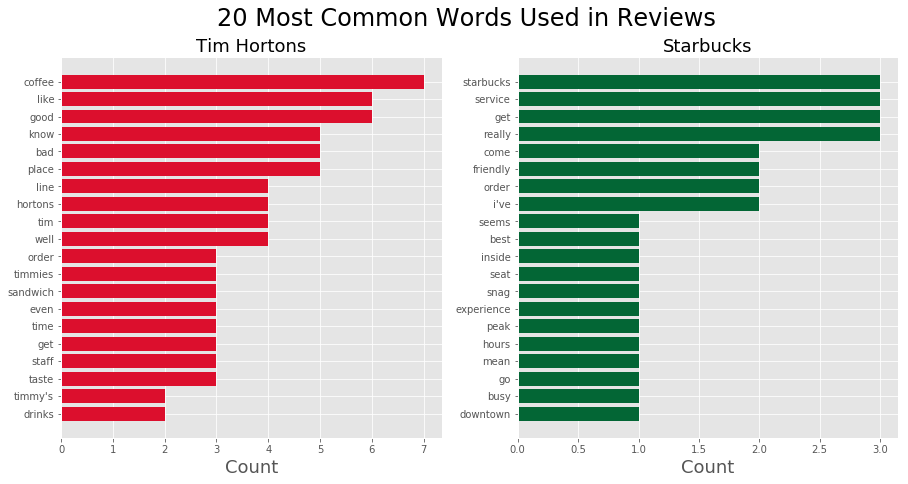

In [224]:
fig, ax = plt.subplots(1,2)

ax[0].barh(y=timmy[:20].word, width=timmy[:20]['count'], color=colors[0])
ax[0].invert_yaxis()

ax[1].barh(y=starry[:20].word, width=starry[:20]['count'], color=colors[1])
ax[1].invert_yaxis()

ax[0].set_title("Tim Hortons", fontsize=18)
ax[1].set_title("Starbucks", fontsize=18)
plt.suptitle("20 Most Common Words Used in Reviews", fontsize=24)
ax[0].set_xlabel("Count", fontsize=18)
ax[1].set_xlabel("Count", fontsize=18)
plt.show()

In [234]:
# Get reviews from users who have reviewed both chains at least once
both_reviews = pd.DataFrame()
unique_users_tims = tims_reviews.user_id.unique()

for user in unique_users_tims:
    if user in starbucks_reviews.user_id:
        both_reviews.append(tims_reviews[tims_reviews.user_id == user])
        both_reviews.append(starbucks_reviews[starbucks_reviews.user_id == user])

review_id                 user_id             business_id  \
3381  mTZvq_y1w1x2_q6QzeGjCA  oSL39s__owii0Me8u-OS9g  uovoaLJV99NdPRgv43sLFQ   
6587  xVDjrNWii51cdDn1U84MaQ  lR2zF-gSOEaNyZVdgDA5Gg  6756R6GyrhnQnxaB19kJtw   
8355  MjwHus6HVB6pPufdV3UzRQ  9ydq1GlwsUlEACfhL5XLog  uovoaLJV99NdPRgv43sLFQ   
8436  bAgw7lPeZdFMw3z5alm6kA  YRcaNlwQ6XXPFDXWtuMGdA  YPLJPAHy_byhlrwceIbN9Q   
9660  ArgPaqzHtaSqMOBsvQspzA  69y7eZP22sPr6fJ_fxGB9g  tGA6DQqySVxIs4AN9Op_aQ   

      stars  useful  funny  cool  \
3381    5.0       0      0     0   
6587    3.0       0      0     0   
8355    1.0       1      0     0   
8436    2.0       6      5     5   
9660    3.0       0      2     0   

                                                   text                 date  
3381  AMAZING!! That's all I have to say.. my mom an...  2014-10-27 01:47:49  
6587  Timmy's is the best for inexpensive coffee and...  2016-05-07 03:46:50  
8355  I would give 0 stars if possible. This Tim Hor...  2017-01-02 16:02:15  
8436  This place is an absolute gong show (on a Satu...  2012-11-06 17:29:29  
9660  I don't know how to describe this place... ah....  2012-03-30 00:32:41